# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1JJp5Q_pjfXYZGiUEm9IObY1OXa5YxnOA/view?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Fall_2023_Lab5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /content/Fall_2023_Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 851308 bytes to /content/Fall_2023_Lab5_Spam_Detection.html


In [ ]:
!python --version

Python 3.10.12


As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [ ]:
!pip uninstall torchtext
!pip install torchtext==0.6

Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchtext-0.16.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchtext/*
Proceed (Y/n)? y
  Successfully uninstalled torchtext-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu118
0.6.0


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'): # "line" refers to the entire string of characters, including the label
  if line[0] == 'h': # label for non-spam texts is "ham"
    print("Non-spam:", line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == 's': # label for spam texts is "spam"
    print("Spam:", line)
    break

Non-spam: ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam: spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
non_spam_count = 0
spam_count = 0

for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    non_spam_count += 1
  elif line[0] == 's':
    spam_count += 1

print('There are', non_spam_count, 'non-spam messages in the dataset.')
print('There are', spam_count, 'spam messages in the dataset.')

There are 4827 non-spam messages in the dataset.
There are 747 spam messages in the dataset.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Disadvantages
> 1. More computationally intensive since a tweet consists of more characters than words; this leads to longer training time, using more resources, etc.
> 2. Some semantic information could be lost when using a character-level RNN; words are more meaningful than individual characters. So, character-level RNNs could struggle to capture broader context which can be a problem if deeper semantic understanding is required.

Advantages
> 1. Useful for tasks where specific character combinations are essential for understanding meaning (i.e., detecting patterns like "lol" or emoticons might be more straightforward at the character level; such combinations are frequently used in SMS, same diea with abbreviations like brb, gtg, wyd)
> 2. Character-level models naturally handle out-of-vocabulary words because they operate at a smaller level; this is good for handling new words or slang words, which may not appear in the dicitonary being used for the model; slang is always evolving so it is best captured at a character-level.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True, # because we are using a sequence (text)
             tokenize=lambda x: x, # building a character level RNN, each character is a seperate token
             batch_first=True, # batch dimension first
             use_vocab=True) # will use vocabulary to map tokens to numerical index

LABEL = torchtext.data.Field(sequential=False, # labels are not sequential
              preprocessing=lambda x: int(x =="spam"), # converting "spam" labels to a 1, and "ham" labels to a 0
              batch_first=True, # batch dimension first
              use_vocab=False, # don't need to track vocab for labels
              is_target=True)

fields = [('label', LABEL), ('sms', text_field)]

# Load the dataset from file
dataset = torchtext.data.TabularDataset(
    "SMSSpamCollection",  # file name
    format='tsv',  # fields are separated by tabs
    fields=fields)

np.random.seed(50)
train, val, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

Having a balanced dataset is imporatant because it avoids having falsely high accuracies. If a dataset contains 950 spam messages and 50 non-spam, then the model could simply classify all samples as spam and still attain a 95% accuracy, even though it is not actually learning how to classify spam vs non-spam.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

text_field.vocab.stoi (string to index) represents a dictionary where the keys are tokens from the vocabulary (in this case the keys would be character strings like 'a', 'b', 'c', etc.), and where the values are the corresponding integers for each token.

text_fiel.vocab.itos (index to string) represents a list where each position in the list corresponds to a token. For example, if letter 'a' has associated integer value of 2 (as given by stoi), it would have a position/index of 2 in the itos list.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

unk represents "unknown". It is used when a token is not found within the vocabulary being used; if the encountered token is not found in the vocabulary, it is replaced with unk.

pad represents "padding". It is used when a padding token (i.e., a token used to increase the length of a phrase/SMS text) is encountered. None of the SMS messages currently have any padding, so pad subsequently would not appear.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
pads = [] # The number of pad tokens in each batch
max_lengths = [] # The maximum SMS length in that batch

for batch in train_iter:
  if i < 10:
    max_length_batch = 0
    pads_in_batch = 0
    for sms in batch.sms:
      if len(sms) > max_length_batch:
        max_length_batch = len(sms)
      for token in sms:
        if token == text_field.vocab.stoi["<pad>"]:
          pads_in_batch += 1

    pads.append(pads_in_batch)
    max_lengths.append(max_length_batch)

    i += 1

print(pads)
print(max_lengths)

[31, 4, 12, 50, 20, 116, 26, 10, 15, 10]
[72, 155, 136, 55, 63, 21, 156, 48, 138, 147]


In [ ]:
for example in train.examples[:5]:
    print(vars(example))

{'label': 1, 'sms': 'Our brand new mobile music service is now live. The free music player will arrive shortly. Just install on your phone to browse content from the top artists.'}
{'label': 0, 'sms': 'Nope watching tv at home... Not going out. V bored...'}
{'label': 1, 'sms': "FREE2DAY sexy St George's Day pic of Jordan!Txt PIC to 89080 dont miss out, then every wk a saucy celeb!4 more pics c PocketBabe.co.uk 0870241182716 £3/wk"}
{'label': 0, 'sms': "I'm tired of arguing with you about this week after week. Do what you want and from now on, i'll do the same."}
{'label': 0, 'sms': 'Ya ok, vikky vl c witin  &lt;#&gt; mins and il reply u..'}


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SpamRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SpamRNN, self).__init__()
        self.name = "5thSpamRNN"
        self.onehot = torch.eye(len(text_field.vocab.itos)) # creates identity matrix of size equal to the vocabulary (i.e., number of characters)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True) #
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.onehot[x] # converting x to its one-hot encoding as per the identity matrix

        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)

        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)

        # Pass the output of the last time step to the classifier

        #### out = self.fc(out[:, -1, :]) # Pooling Option #1

        #### out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1) # Pooling Option #2
        #### self.fc(out)

        out = self.fc(torch.max(out, dim=1)[0]) # Pooling Option #3

        return out

In [ ]:
print(len(text_field.vocab.itos))

114


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_model_name(name, learning_rate):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}".format(name, learning_rate)

    return path

In [ ]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total = 0, 0
    for batch in data_loader:
        msgs = batch.sms
        labels = batch.label
        output = model(msgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
## Validation Loss

def get_val_loss(model, valid_loader):
    total_val_loss = 0.0
    i = 0
    criterion = nn.CrossEntropyLoss()
    for batch in valid_loader:
        msgs = batch.sms
        labels = batch.label
        pred = model(msgs)
        loss = criterion(pred, labels)
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

In [ ]:
## Training Code

def train_rnn(model, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    torch.manual_seed(42) # setting the random seed

    epochs, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    i = 0 # epoch counter
    for epoch in range(num_epochs):

        total_train_loss = 0.0
        n = 0 # keeping track of msgs in each batch to get get the average loss per batch

        for batch in train_loader:
            msgs = batch.sms
            labels = batch.label
            optimizer.zero_grad()
            pred = model(msgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            n += 1

        epochs.append(i)
        train_loss.append(float(total_train_loss)/(n + 1)) # append average batch loss at the end of this epoch
        val_loss.append(get_val_loss(model, valid_loader)) # append val loss at the end of this epoch
        train_acc.append(get_accuracy(model, train_loader)) # append train acc at the end of this epoch
        val_acc.append(get_accuracy(model, valid_loader)) # append val acc at the end of this epoch

        print("Finished Epoch: {0} | Training Acc: {1} | Train Loss: {2}| Val Accuracy {3} | Val Loss {4} ".format(
              i+1, train_acc[i],train_loss[i], val_acc[i], val_loss[i]))

        i += 1

    # plotting
    plt.title("Losses")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracies")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    model_path = get_model_name(model.name,learning_rate)
    torch.save(model.state_dict(), model_path)

Finished Epoch: 1 | Training Acc: 0.595115467685662 | Train Loss: 0.688625053669277| Val Accuracy 0.7964125560538117 | Val Loss 0.6525172276629342 
Finished Epoch: 2 | Training Acc: 0.6605748463199868 | Train Loss: 0.676574348775964| Val Accuracy 0.7757847533632287 | Val Loss 0.6441393478049172 
Finished Epoch: 3 | Training Acc: 0.6956305034058814 | Train Loss: 0.661196957450164| Val Accuracy 0.7336322869955157 | Val Loss 0.6486114776796765 
Finished Epoch: 4 | Training Acc: 0.8341917262003655 | Train Loss: 0.5966777775632708| Val Accuracy 0.9210762331838565 | Val Loss 0.3125233165919781 
Finished Epoch: 5 | Training Acc: 0.8378468184083735 | Train Loss: 0.4202335455699971| Val Accuracy 0.9300448430493273 | Val Loss 0.2660221325026618 
Finished Epoch: 6 | Training Acc: 0.8881874065459379 | Train Loss: 0.32113011812693193| Val Accuracy 0.9022421524663677 | Val Loss 0.2668363449888097 
Finished Epoch: 7 | Training Acc: 0.8996511048346901 | Train Loss: 0.29431374378894504| Val Accuracy 0.

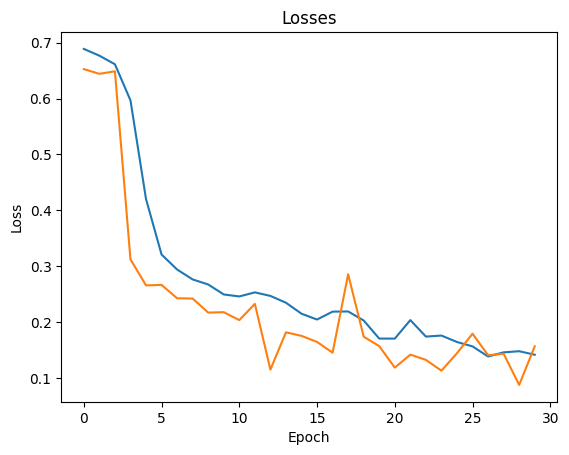

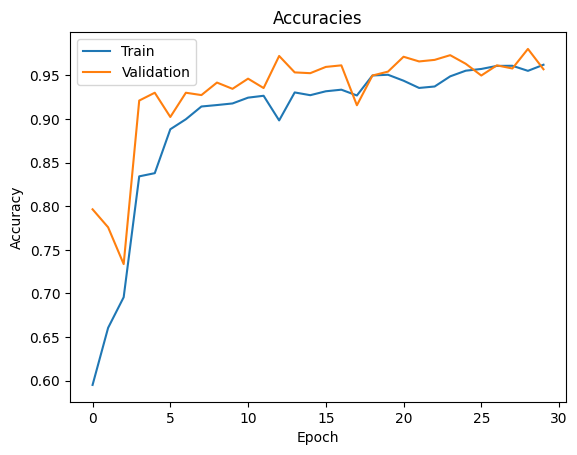

In [ ]:
## First Training Attempt

firstModel = SpamRNN(64) # hidden size of 64

train_rnn(firstModel, train_iter, val_iter, 30, 0.0001) # 30 epochs, LR=0.0001


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

For this assignment, I will be tuning the following hyperparameters:

*   Learning Rate
*   Number of Epochs
*   Hidden Size
*   Output Pooling Method





**Trial 1: LR: 0.0001, Epochs: 30, Hidden Size: 64, Pooling Method: out = self.fc(out[:, -1, :])**

***Final Result:*** Finished Epoch: 30 | Training Acc: 0.9621199534806446 | Train Loss: 0.14204490976653208| Val Accuracy 0.95695067264574 | Val Loss 0.1571113555174735

Evidently, the original model performed very well. However, one can see that there is some "noisiness" in the loss/accuracy curves. As such, for the next trial I will decrease the learning rate to 0.00001. I will also reduce epochs since there did not seem to be drastic improvement after 20 epochs.

**Trial 2: LR: 0.00001, Epochs: 20, Hidden Size: 64, Pooling Method: out = self.fc(out[:, -1, :])**

***Final Result:*** Finished Epoch: 20 | Training Acc: 0.712742980561555 | Train Loss: 0.6532759945643576| Val Accuracy 0.7417040358744394 | Val Loss 0.6482188221481111

This model performed significantly worse than the first model. For the accuracy curves, the training one increases slowly (and seems like it would continue increasing with more epochs), but the validation one actually is decreasing (and seems like it would continue decreasing with more epochs). As such, this model is likely overfit/has a learning rate which is too small. As such, for the next model, I will bring the learning rate back up to 0.0001. I will next investigate the effect of decreasing hidden size.

**Trial 3: LR: 0.0001, Epochs: 15, Hidden Size: 32, Pooling Method: out = self.fc(out[:, -1, :])**

***Final Result:*** Finished Epoch: 15 | Training Acc: 0.9023093537132414 | Train Loss: 0.27647071827791236| Val Accuracy 0.9479820627802691 | Val Loss 0.2021325369262033

This model performed slightly worse than the baseline (i.e., Trial 1), indicating that decreasing the hidden size results in poorer performance. As such, for the next trial I will increase hidden size to 96 and also try out a different pooling method.

**Trial 4: LR: 0.0001, Epochs: 15, Hidden Size: 96, Pooling Method: out = self.fc(torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)) **

***Final Result:*** Finished Epoch: 15 | Training Acc: 0.9574680179431799 | Train Loss: 0.12296538478449771| Val Accuracy 0.9721973094170404 | Val Loss 0.09813691137565507

This model seems to have better final accuracies when compared to Trial 1, indicating that further increasing the hidden size and changing the output pooling had positive effects. However, this trial achieved its final accuracy after only a few epochs, and the validaiton loss did spike significantly at about 4 epochs (odd behaviour). For Trial 5, I will investigate another pooling option while keeping all else the same.

**Trial 5: LR: 0.0001, Epochs: 15, Hidden Size: 96, Pooling Method: out = self.fc(torch.max(out, dim=1)[0])**

***Final Result:*** Finished Epoch: 15 | Training Acc: 0.9685994351221133 | Train Loss: 0.12644858537731987| Val Accuracy 0.95695067264574 | Val Loss 0.14929077443149355

This model performed similarly to Trials 1 and 4; just slightly better than Trial 1, and slightly worse than Trial 4. The accuracy curves also seemed to plateau/only marginally keep increasing after about 5 epochs. Unlike Trial 4, it did not exhibit the spikes in loss at around 4 epochs.

---

I decided to go with Trial 5, as it was only very slightly less accurate than Trial 4, and did not exhibit any odd fluctuations in accuracy/loss.

---

Finished Epoch: 1 | Training Acc: 0.8135902973915933 | Train Loss: 0.6800150422673477| Val Accuracy 0.6600896860986547 | Val Loss 0.6649912479850981 
Finished Epoch: 2 | Training Acc: 0.846486127263665 | Train Loss: 0.629587940165871| Val Accuracy 0.6869955156950672 | Val Loss 0.63551098604997 
Finished Epoch: 3 | Training Acc: 0.8170792490446918 | Train Loss: 0.47567725212950457| Val Accuracy 0.6430493273542601 | Val Loss 0.6698309282461802 
Finished Epoch: 4 | Training Acc: 0.9443429141053331 | Train Loss: 0.38821784908834256| Val Accuracy 0.9417040358744395 | Val Loss 0.4810810147060288 
Finished Epoch: 5 | Training Acc: 0.9411862435620535 | Train Loss: 0.32922517210245134| Val Accuracy 0.9641255605381166 | Val Loss 0.3026276272204187 
Finished Epoch: 6 | Training Acc: 0.9486625685329789 | Train Loss: 0.2503288561968427| Val Accuracy 0.9605381165919282 | Val Loss 0.24706102866265509 
Finished Epoch: 7 | Training Acc: 0.955640471839176 | Train Loss: 0.2017551338006007| Val Accuracy 0

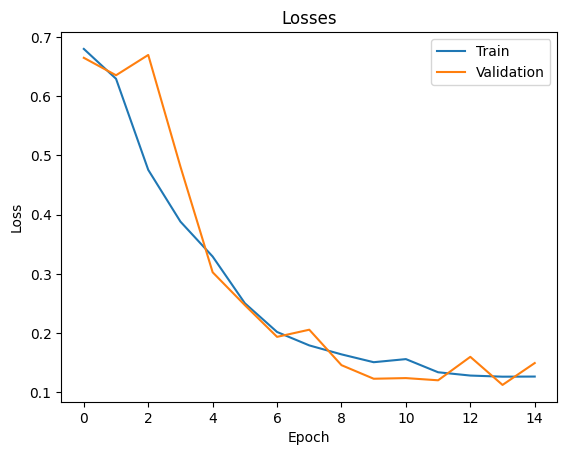

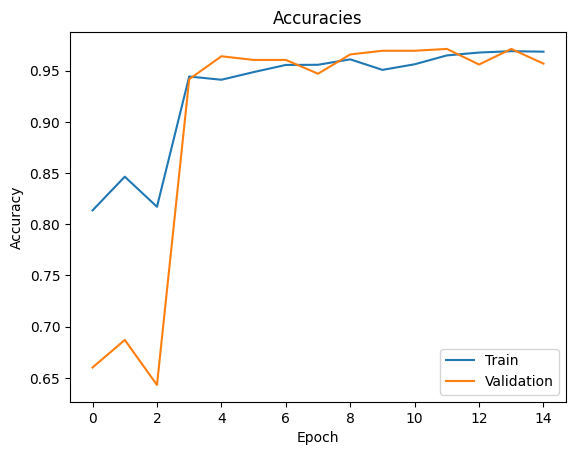

In [ ]:
## Fifth Training Attempt

fifthModel = SpamRNN(96) # hidden size of 96

train_rnn(fifthModel, train_iter, val_iter, 15, 0.0001) # 15 epochs, LR=0.0001

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
final_model = SpamRNN(96)
state = torch.load('model_5thSpamRNN_lr0.0001')
final_model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
false_positive = 1 - get_accuracy(final_model, valid_nospam_iter)
false_negative = 1 - get_accuracy(final_model, valid_spam_iter)

print("The model's false positive rate is:", false_positive)
print("The model's false negative rate is:", false_negative)

The model's false positive rate is: 0.03112033195020747
The model's false negative rate is: 0.05960264900662249


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive would mean falsely assigning as spam. This can result in one not receiving important messages.

A false negative would mean falsely assigning as not spam. This would not be as problematic as a false positive, as the user would likely be able to tell if the message is spam based on content of the message and the sender. False negatives are annoying, but would not be as problematic as a false positive, which, as stated before, can result in missing important messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
print("The final test accuracy of my model is:", get_accuracy(final_model, test_iter))

The final test accuracy of my model is: 0.9560143626570916


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
false_positive_test = 1 - get_accuracy(final_model, test_nospam_iter)
false_negative_test = 1 - get_accuracy(final_model, test_spam_iter)

print("The model's false positive rate on the test set is:", false_positive_test)
print("The model's false negative rate on the test set is:", false_negative_test)

The model's false positive rate on the test set is: 0.0423728813559322
The model's false negative rate on the test set is: 0.05294117647058827


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
## First we need to tokenize msg:

msg_tokens = []

for character in msg:
  msg_tokens.append(torch.tensor(text_field.vocab.stoi[character]))

## Next we need to stack all the tokens (to make a 2D tensor):

x = torch.stack(msg_tokens)

## Then we need to add a third dimension using unsqueeze, as our model anticipates 3D tensor

x.unsqueeze_(0)

prob = F.softmax(final_model(x), dim=1)[0][1].item()

print("According to my model, the probability that the SMS message is spam is:", prob)

According to my model, the probability that the SMS message is spam is: 0.04015926644206047


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I do not think detecting spam is a difficult task. The simple RNN studied in this lab was able to obtain very high accuracies in a short amount of time, which speak to the difficulty of the task. Especially in comaprison to other deep learning tasks, the classification of spam messages is on the simpler side.


One method could be building a simple ANN which takes in a flattened version of the SMS (the 2D one-hot encoding matrix is flattened to a 1D vector), and predicts spam vs not spam. Using an ANN would be simple and inexpensive compared to an RNN.

Another baseline model which could be used is an algorithm which assigns points to a message based on whether or not that text contains features which are typically associated with spam messages.

For example, the model could work by taking words as inputs (where words are assumed to be separated by a space). If the word being looked at belongs to a "Common Spam Word" list defined by the person making the model (i.e., words like "free", "win", "credit", account"...", a point is added to the total point counter for that SMS. Aside from being compared to that list, the model would also check if the word belongs to a list of common words (i.e., one could import a dictionary as a list). If the word DOES NOT belong to that list, it would indicate that there is a typo, another common feature of spam messages; such words would get assigned a point as well.

If a message accumulates a certain number of points (i.e., crosses a threshhold set by the individual creating the model), then it would be assigned as spam.

